In [174]:
#import face_recognition as fr
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
import glob
import numpy as np
import re
import pandas as pd
import cv2
face_cascade = cv2.CascadeClassifier('gui_2/assets/haarcascade_frontalface_default.xml')
HEIGHT, WIDTH =48,48
other_emotions =  [ 'fear', 'anger', 'disgust', 'neutral']
initial_emotions = ['sadness','happiness', 'surprise']

In [175]:
def get_emotion(x,initial):
    if initial:
        if x in initial_emotions:
            return x
        else:
            return "other"
    else: 
        if x in other_emotions:
            return x
        else:
            return "other" 

In [176]:
paths = ["data/all/train/","data/all/test/"]#["data/CK_cut/"]# #["data/CK+/","data/fer/train/"]
# data  = listdir(path)
ignore = ["morralla",".DS_Store","contempt"]
imgs = []
state = []

## Datos para entrenar emociones iniciales

In [137]:
for path in paths:
    for item in listdir(path):
        print(item)
        if item not in ignore:
            imgs.extend([f"{path}{item}/{p}" for p in listdir(f"{path}{item}")])
            
            if item in initial_emotions:
                state.extend([item for p in listdir(f"{path}{item}")])
            else:
                state.extend(["other" for p in listdir(f"{path}{item}")])

surprise
disgust
anger
neutral
happiness
fear
sadness
surprise
disgust
anger
neutral
happiness
fear
sadness


## Datos para entrenar resto emociones 

In [177]:
for path in paths:
    for item in listdir(path):
        print(item)
        if item not in ignore:
            if item in other_emotions:
                imgs.extend([f"{path}{item}/{p}" for p in listdir(f"{path}{item}")])
                state.extend([item for p in listdir(f"{path}{item}")])

surprise
disgust
anger
neutral
happiness
fear
sadness
surprise
disgust
anger
neutral
happiness
fear
sadness


In [178]:
len(imgs),set(state)

(25230, {'anger', 'disgust', 'fear', 'neutral'})

## *********************************************************

In [179]:
errs = []
try:
    imgs_ = []
    for p in imgs:
        temp = Image.open(p)
        save = temp.copy()
        imgs_.append(save)
        temp.close()
except:
    errs.append(p)

In [180]:
imgs_array = []
HEIGHT, WIDTH =48,48
for f in imgs_:
    img = f.convert("L").resize((HEIGHT, WIDTH))
    imgs_array.append(np.array(img))

In [181]:
imgs_array = [el/255 for el in imgs_array]
imgs_array = np.array(imgs_array)

In [182]:
imgs_array= imgs_array.reshape((len(imgs_array),48,48,1))

In [183]:
imgs_array.shape

(25230, 48, 48, 1)

## Con este modo de cargar imagenes, filtramos caras con cv2

In [107]:

imgs = []
for path in paths:
    for item in listdir(path):
        if item not in ignore:
            imgs.extend([{"path": f"{path}{item}/{p}", "emotion": get_emotion(item,True)}for p in listdir(f"{path}{item}")])

In [109]:
imgs_ = []
state = []
for p in imgs:
    temp = cv2.imread(p["path"],0)
    faces = face_cascade.detectMultiScale(temp, 1.1, 5) #1.1 factor scale, cuanto  disminuye imagen entre pasos
                                                        #5 MIN nEIGHBORS cuantos vecinos cada posible 
                                                        # rectangulo considerar para prediccion
                                                        # (valor minimo px de la cara detectada)
                                                        # (valor maximo px)
            
    if len(faces)==1:
        for (x,y,w,h) in faces:
            recortada = temp[y:y+h, x:x+w]
            recortada = cv2.resize(recortada,(HEIGHT, WIDTH))
            imgs_.append(recortada)
            state.append(p["emotion"])
    
        
imgs_ = [el/255 for el in imgs_]
imgs_array = np.array(imgs_)


In [110]:
imgs_array.shape

(22087, 48, 48)

In [122]:
imgs_array= imgs_array.reshape((len(imgs_array),48,48,1))

# Preparamos entrenamiento

In [184]:
y=pd.DataFrame(state)
y_dummies = pd.get_dummies(y)

In [185]:
y_dummies

,0_anger,0_disgust,0_fear,0_neutral
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
25225,0,0,1,0
25226,0,0,1,0
25227,0,0,1,0
25228,0,0,1,0


In [186]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs_array,y_dummies)

In [187]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten,BatchNormalization,Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D,MaxPooling2D
from tensorflow.keras.optimizers import Adam, Nadam, SGD, Adamax
import keras

In [188]:
# opt = Adam(learning_rate=0.001)

In [189]:
model = Sequential()
# 1-conv
model.add(Conv2D(64,(3,3),padding='same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2-conv
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3-conv
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4-conv
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(4,activation='softmax'))

opt = Adam(learning_rate=0.0005)

model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
#model.summary()


In [190]:
from keras.models import Sequential, load_model, model_from_json
from keras import callbacks, optimizers
import tensorflow as tf
from datetime import date

fecha=str(date.today().year)+str(date.today().month)+str(date.today().day)    
symbol = 'other_emotions'
h5 = symbol + fecha + '_v4[fea-ang-dis-neu].h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                       monitor='loss',
                                       verbose=0,
                                       save_best_only=True,
                                       #save_weights_only=True,
                                       mode='auto',
                                       save_freq=1)
callback = [checkpoint]

modelo = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 5000,callbacks = callback,validation_split = 0.1)

Epoch 1/5000
533/533 [==============================] - 109s 204ms/step - loss: 1.1036 - accuracy: 0.5551 - val_loss: 2.0242 - val_accuracy: 0.5404
Epoch 2/5000
533/533 [==============================] - 7s 13ms/step - loss: 0.9560 - accuracy: 0.6021 - val_loss: 0.9616 - val_accuracy: 0.5938
Epoch 3/5000
533/533 [==============================] - 7s 13ms/step - loss: 0.8719 - accuracy: 0.6353 - val_loss: 0.8950 - val_accuracy: 0.6350
Epoch 4/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.8118 - accuracy: 0.6684 - val_loss: 1.1639 - val_accuracy: 0.5906
Epoch 5/5000
533/533 [==============================] - 8s 15ms/step - loss: 0.7720 - accuracy: 0.6861 - val_loss: 0.9937 - val_accuracy: 0.6403
Epoch 6/5000
533/533 [==============================] - 7s 13ms/step - loss: 0.7302 - accuracy: 0.7017 - val_loss: 1.1243 - val_accuracy: 0.5061
Epoch 7/5000
533/533 [==============================] - 6s 12ms/step - loss: 0.7026 - accuracy: 0.7161 - val_loss: 0.8581 - val

533/533 [==============================] - 6s 11ms/step - loss: 0.0822 - accuracy: 0.9712 - val_loss: 1.2850 - val_accuracy: 0.6952
Epoch 58/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0802 - accuracy: 0.9732 - val_loss: 1.2558 - val_accuracy: 0.7507
Epoch 59/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0851 - accuracy: 0.9701 - val_loss: 2.0434 - val_accuracy: 0.7290
Epoch 60/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0777 - accuracy: 0.9716 - val_loss: 1.3349 - val_accuracy: 0.7559
Epoch 61/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0767 - accuracy: 0.9743 - val_loss: 1.1689 - val_accuracy: 0.7480
Epoch 62/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0652 - accuracy: 0.9767 - val_loss: 1.1956 - val_accuracy: 0.7554
Epoch 63/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0682 - accuracy: 0.9768 - val_loss: 1.2988 - val_accuracy:

533/533 [==============================] - 6s 11ms/step - loss: 0.0376 - accuracy: 0.9871 - val_loss: 1.7651 - val_accuracy: 0.7544
Epoch 114/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0361 - accuracy: 0.9873 - val_loss: 1.4628 - val_accuracy: 0.7470
Epoch 115/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0383 - accuracy: 0.9871 - val_loss: 2.1578 - val_accuracy: 0.7385
Epoch 116/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0457 - accuracy: 0.9837 - val_loss: 1.6264 - val_accuracy: 0.7544
Epoch 117/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0300 - accuracy: 0.9900 - val_loss: 1.4372 - val_accuracy: 0.7427
Epoch 118/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0362 - accuracy: 0.9878 - val_loss: 1.3780 - val_accuracy: 0.7533
Epoch 119/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0364 - accuracy: 0.9861 - val_loss: 1.4273 - val_acc

Epoch 169/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0290 - accuracy: 0.9898 - val_loss: 1.6618 - val_accuracy: 0.7301
Epoch 170/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0279 - accuracy: 0.9903 - val_loss: 1.3684 - val_accuracy: 0.7485
Epoch 171/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0257 - accuracy: 0.9910 - val_loss: 1.6768 - val_accuracy: 0.7496
Epoch 172/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0336 - accuracy: 0.9887 - val_loss: 1.3806 - val_accuracy: 0.7575
Epoch 173/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0251 - accuracy: 0.9918 - val_loss: 1.7230 - val_accuracy: 0.7559
Epoch 174/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0238 - accuracy: 0.9926 - val_loss: 1.7527 - val_accuracy: 0.6730
Epoch 175/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0331 - accuracy: 0.9891 - val_loss: 1

Epoch 225/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0221 - accuracy: 0.9922 - val_loss: 1.8973 - val_accuracy: 0.7623
Epoch 226/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0172 - accuracy: 0.9936 - val_loss: 2.2957 - val_accuracy: 0.7612
Epoch 227/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0249 - accuracy: 0.9924 - val_loss: 1.7378 - val_accuracy: 0.7691
Epoch 228/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0275 - accuracy: 0.9913 - val_loss: 1.7988 - val_accuracy: 0.7618
Epoch 229/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0230 - accuracy: 0.9929 - val_loss: 2.0614 - val_accuracy: 0.7591
Epoch 230/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0187 - accuracy: 0.9940 - val_loss: 1.7746 - val_accuracy: 0.7734
Epoch 231/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0196 - accuracy: 0.9932 - val_loss: 1

Epoch 281/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0179 - accuracy: 0.9941 - val_loss: 1.7501 - val_accuracy: 0.7633
Epoch 282/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0178 - accuracy: 0.9938 - val_loss: 2.2430 - val_accuracy: 0.7596
Epoch 283/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0144 - accuracy: 0.9953 - val_loss: 1.9777 - val_accuracy: 0.7612
Epoch 284/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0167 - accuracy: 0.9942 - val_loss: 1.7875 - val_accuracy: 0.7602
Epoch 285/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0165 - accuracy: 0.9945 - val_loss: 2.0073 - val_accuracy: 0.7596
Epoch 286/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0182 - accuracy: 0.9932 - val_loss: 1.6143 - val_accuracy: 0.7496
Epoch 287/5000
533/533 [==============================] - 6s 11ms/step - loss: 0.0167 - accuracy: 0.9941 - val_loss: 1

KeyboardInterrupt: 

In [150]:
paths = ["data/predict/"]
# data_pred  = listdir(path)
ignore = ["morralla",".DS_Store","contempt"]
imgs_pred = []
state_pred = []
im_pred = {}

In [151]:
for path in paths:
    for item in listdir(path):
        if item not in ignore:
            imgs_pred.extend([{"path": f"{path}{item}/{p}", "emotion": get_emotion(item,True)}for p in listdir(f"{path}{item}")])
            #state_pred.extend([item for p in listdir(f"{path}{item}")])



In [152]:
len(imgs_pred)

127

In [153]:
from keras.models import load_model

In [154]:
#model = load_model('intial_emotions_2_20211116_v1.h5')

In [155]:
imgs_pred_ = []
state_pred = []
for p in imgs_pred:
    temp = cv2.imread(p["path"],0)
    faces = face_cascade.detectMultiScale(temp, 1.05, 5)
    if len(faces)>0:
        for (x,y,w,h) in faces:
            recortada = temp[y:y+h, x:x+w]
            recortada = cv2.resize(recortada,(HEIGHT, WIDTH))
            imgs_pred_.append(recortada)
            state_pred.append(p["emotion"])
    
        
imgs_pred_ = [el/255 for el in imgs_pred_]
imgs_pred_ = np.array(imgs_pred_)
imgs_pred_= imgs_pred_.reshape((len(imgs_pred_),48,48,1))

In [156]:
len(imgs_pred_)

128

In [157]:
len(state_pred)

128

In [158]:
prediction = model.predict(imgs_pred_)

In [159]:
state_pred

['surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'surprise',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'other',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happiness',
 'happine

In [160]:
prediction[:5]

array([[6.8096431e-11, 8.9898246e-04, 1.0062725e-08, 9.9910104e-01],
       [4.7656874e-12, 4.1784510e-01, 1.1044306e-02, 5.7111061e-01],
       [9.9592125e-01, 3.7983016e-03, 2.8208031e-12, 2.8042117e-04],
       [1.0165893e-04, 2.5761712e-02, 7.8899723e-07, 9.7413582e-01],
       [1.5893158e-06, 1.0128866e-01, 3.8984188e-04, 8.9831996e-01]],
      dtype=float32)

In [161]:
prediction.argmax(axis = -1)


array([3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,
       0, 0, 3, 0, 0, 0, 2, 0, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1,
       2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1])

In [162]:
cats= y_dummies.columns
cats = [x.replace("0_","") for x in cats]

In [163]:
cats

['happiness', 'other', 'sadness', 'surprise']

In [164]:
len(prediction)

128

In [165]:
states_model = []
i=0
for i in range(len(prediction)):
    states_model.append(cats[prediction[i].argmax()])
    print(state_pred[i],cats[prediction[i].argmax()])

surprise surprise
surprise surprise
surprise happiness
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise surprise
surprise other
surprise surprise
surprise surprise
surprise other
surprise surprise
surprise surprise
other sadness
other other
other other
other other
other other
other other
other other
other other
other other
other other
other other
other other
other other
other sadness
other other
other sadness
other other
other other
other other
other other
other other
other other
other other
other other
other other
other other
other other
other other
other sadness
other other
other other
other other
other other
other other
other other
other other
other other
other other
other other
other other
other sadness
other other
other other
other other
other other
other sadness
other other
other other
other other
other other
other sadness
o

In [166]:
from sklearn.metrics import accuracy_score

In [167]:
accuracy_score(state_pred,states_model)

0.8046875

In [168]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns


In [169]:
conf = confusion_matrix(states_model, state_pred)
conf = pd.DataFrame(conf,columns=cats, index=cats)

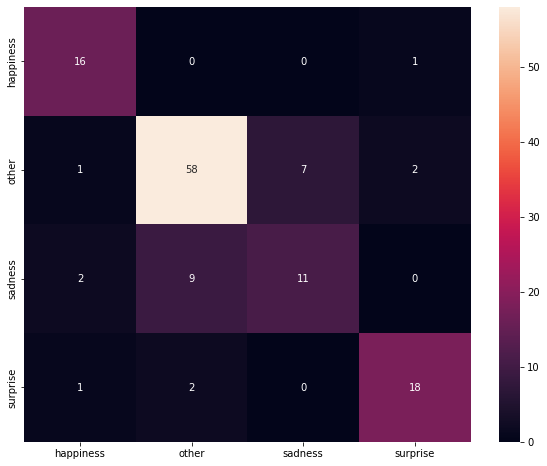

In [170]:
plt.figure(figsize=(10,8))
heatmap = sns.heatmap(conf, annot=True)

